In [27]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore

import nibabel as nib
from nilearn.glm.first_level import glover_hrf
from nilearn.plotting import plot_anat, plot_epi
from nilearn.image import mean_img, resample_img

main_path = "/jukebox/PNI-classes/students/NEU502/2023-NEU502B/wlong/multilang/"
fig_path = "../../figures"
subject_name = "S1"

In [34]:
S1_path = "derivatives/fmriprep/sub-002/ses-01/func/sub-002_ses-01_task-language_desc-confounds_timeseries.tsv"
# S2_path = "derivatives/fmriprep/sub-005/ses-01/func/sub-005_ses-01_task-language_desc-confounds_timeseries.tsv"

## Importing confounds
data_path = os.path.join(main_path, "data/bids/")
confounds_f = os.path.join(data_path, S1_path)
confounds_df = pd.read_table(confounds_f, sep='\t')

### Head motion error

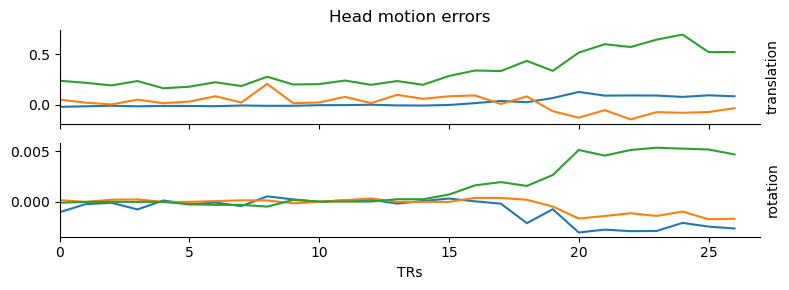

In [35]:
hm_labels = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']
hm = confounds_df[hm_labels].values

# Plot head motion parameters
fig, axs = plt.subplots(2, 1, figsize=(8, 3), sharex=True)

axs[0].set_title("Head motion errors")
axs[0].plot(hm[:, :3])
axs[0].set_ylabel('translation')
axs[0].yaxis.set_label_position("right")
axs[1].plot(hm[:, 3:])
axs[1].set(xlabel='TRs', ylabel='rotation', xlim=(0, hm.shape[0]))
axs[1].yaxis.set_label_position("right")
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(fig_path, f"{subject_name}_head_motion.png"), dpi=300)

### Component based noise correction method (CompCor)

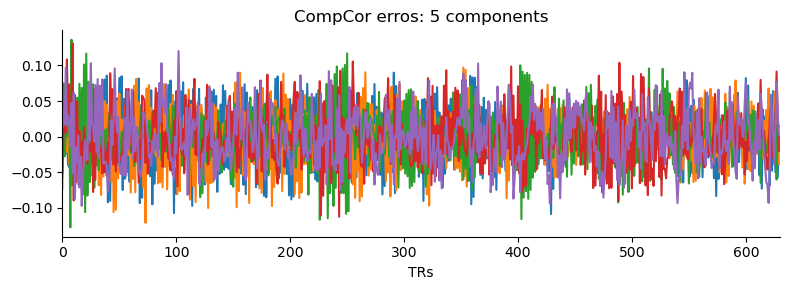

In [15]:
# Extract aCompCor signals from confounds table
n_trs = 630
tr = 1.5
acompcor_n = 5
acompcor_df = confounds_df.filter(regex='a_comp_cor').iloc[:, :acompcor_n]
acompcor_labels = acompcor_df.columns.tolist()
acompcor = acompcor_df.values
acompcor = acompcor[: n_trs,:]

# Plot aCompCor regressors:
fig, ax = plt.subplots(figsize=(8, 3))
ax.set_title(f"CompCor erros: {acompcor_n} components")
ax.plot(np.arange(n_trs), acompcor)
ax.set(xlim=(0, n_trs), xlabel='TRs')
sns.despine()

plt.tight_layout()
plt.savefig(os.path.join(fig_path, f"{subject_name}_CompCor.png"), dpi=300)

### Framewise displacement

5 bad volumes


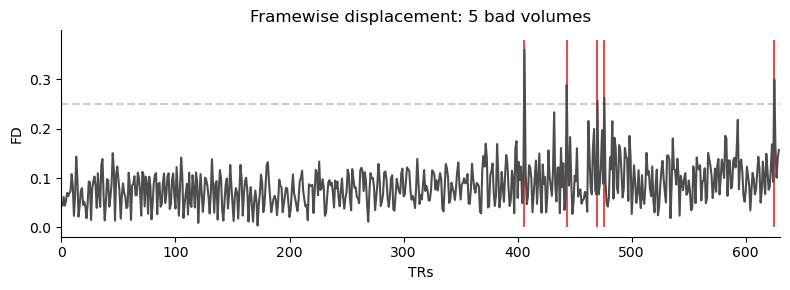

In [16]:
# Define FD threshold
fd_threshold = 0.25

# Extract framewise displacement
fd = confounds_df['framewise_displacement'].values

# Identify bad volumes
bad_vols = np.argwhere(fd > fd_threshold).ravel()
n_bad = bad_vols.shape[0]
print(f'{n_bad} bad volumes')

# Construct scrubbers
censors = np.zeros((fd.shape[0], n_bad))
censors[bad_vols, np.arange(n_bad)] = 1
censor_labels = [f'censor{c}' for c in np.arange(censors.shape[1])]

# Plot the FD
fig, ax = plt.subplots(1,1,figsize=(8,3))
ax.plot(fd, c='.3')
ax.hlines(fd_threshold, 0, fd.shape[0], colors='.8',
          linestyle='--', zorder=-1)
ax.vlines(bad_vols, 0, np.nanmax(fd) + .02, colors='tab:red',
          zorder=0, alpha=.8)
ax.set(xlim=(0, fd.size), xlabel='TRs', ylabel='FD')
ax.set_title(f"Framewise displacement: {n_bad} bad volumes")
sns.despine()

plt.tight_layout()
plt.savefig(os.path.join(fig_path, f"{subject_name}_FD.png"), dpi=300)

In [6]:
confounds = np.column_stack([np.ones(n_trs), hm, censors, acompcor])
confound_labels = ['intercept'] + hm_labels + censor_labels + acompcor_labels

np.save(os.path.join(main_path, "preprocessed_data/confounds.npy"), 
        {'confounds': confounds, 
         'confound_labels': confound_labels})

### Loading in BOLD data

In [7]:
func_path = os.path.join(data_path, 'sub-002/ses-01/func/sub-002_ses-01_task-language_bold.nii.gz')
anat_path = os.path.join(data_path, 'sub-002/ses-01/anat/sub-002_ses-01_T1w.nii.gz')

func_data = nib.load(func_path).get_fdata()
mask = nib.load(anat_path).get_fdata().astype(bool)

In [8]:
# get auditory mask
# source of auditory mask: https://github.com/ThomasYeoLab/CBIG/tree/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI
# left hemisphere aud is 137-146 inclusive. right hem is 336-344. if you change the parcel file, you will need to go the the 
aud = np.hstack((np.arange(137, 147), np.arange(336, 345)))
masker_path = 'Schaefer2018_400Parcels_Kong2022_17Networks_order_FSLMNI152_2mm.nii.gz'
cut_coords = (60, -25, 2)
aud_masker = nib.load(os.path.join(main_path, "masks", masker_path))
aud_masker_data = aud_masker.get_fdata()
aud_masker_data = np.where(np.isin(aud_masker_data, aud), 1., 0)
aud_masker_img = nib.Nifti1Image(aud_masker_data, affine=aud_masker.affine)

# resample mask to match functional data
func_path = os.path.join(data_path, 'sub-002/ses-01/func/sub-002_ses-01_task-language_bold.nii.gz')
func_img = nib.load(func_path)
func_data = func_img.get_fdata()

masker = resample_img(aud_masker_img, func_img.affine, target_shape=func_data.shape[:3], interpolation='nearest')
mask_aud = func_data.transpose(3, 0, 1, 2) * masker.get_fdata()  #using the apply mask function wasn't working at first
mask_aud = nib.Nifti1Image(mask_aud.transpose(1, 2, 3, 0), affine=func_img.affine)

In [9]:
bold_masked = func_data[masker.get_fdata().astype(bool)].T
print('masked data shape:', bold_masked.shape)

masked data shape: (630, 2913)


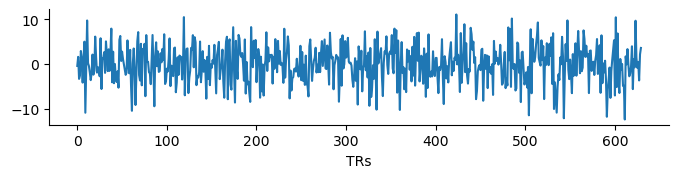

In [10]:
from nilearn.signal import clean
high_pass = 1/128

# Re-run confound regression with high-pass filter
bold_clean = clean(bold_masked, 
                   confounds=confounds, 
                   detrend=True,
                   high_pass=high_pass, 
                   standardize='psc', 
                   t_r=tr)

# Plot an arbitrary voxel time series
voxel = 100
fig, ax = plt.subplots(figsize=(8, 1.5))
ax.plot(bold_clean[:, voxel])
ax.set_xlabel('TRs')
sns.despine()